# LTFS Data Science FinHack 3 Solution

In [305]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [306]:
try: #If running in colab 
    import google.colab
    !pip install --upgrade --no-cache-dir catboost
    !pip install --upgrade --no-cache-dir seaborn
    !pip install --upgrade --no-cache-dir featuretools
    !pip install --upgrade --no-cache-dir xgboost
    !pip install --upgrade --no-cache-dir tqdm
    !pip install --upgrade --no-cache-dir psutil
    !pip install --upgrade --no-cache-dir openpyxl
    !pip install --upgrade --no-cache-dir category_encoders

    # https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM
    !cmake -DUSE_GPU=1 ./
    !make -j$(nproc)
    !pip install --upgrade --no-cache-dir setuptools pandas numpy scipy scikit-learn
    %cd /content/LightGBM/python-package
    !python setup.py install --precompile

    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content
    %mkdir submissions
    %mkdir storage
    
    IN_COLAB = True
except:
    IN_COLAB = False

In [307]:
import os
import re
import psutil
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.notebook import tqdm
tqdm.pandas()

import featuretools as ft
from tabulate import tabulate
from collections import Counter
from collections import namedtuple
from pathlib import Path

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold

import catboost as cgb
import xgboost as xgb
import lightgbm as lgb

from category_encoders import OrdinalEncoder
from datetime import datetime

In [308]:
assert(sklearn.__version__ == '0.24.1')
assert(cgb.__version__ == '0.24.4')
assert(xgb.__version__ == '1.3.3')
    
if IN_COLAB:
    assert(lgb.__version__ == '3.1.1.99')
else:
    assert(lgb.__version__ == '3.1.1')

In [366]:
def plot_countplot(series_):
    """
    https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count
    :param series_:
    :return:
    """
    sns.set_style("whitegrid", {'axes.grid': False})
    headers = [series_.name, 'Count', 'Percentage']
    value_counts = series_.value_counts()
    value_counts_norm = series_.value_counts(normalize=True)
    table = [[
        v, value_counts[v], round(value_counts_norm[v], 3)
    ] for v in value_counts.index]
    print(tabulate(table, headers, tablefmt="psql"))
    sns.countplot(y=series_, orient='horizontal', order=value_counts.index)

def date_to_integer(dt_time):
    return 10_000 * dt_time.year + 100 * dt_time.month + dt_time.day

def run_LGB(params, train, test, feature_names, n_folds=10, seed=0, return_models=False):
    """
    https://stackoverflow.com/questions/56303572/how-can-i-solve-this-unknown-label-type-error
    """
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')

    num_classes = np.unique(y).size
    preds = np.zeros((test.shape[0], params['num_classes']))

    models = list()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val, reference=dtrain)

        bst = lgb.train(
            params=params,
            train_set=dtrain,
            valid_sets=[dtrain, dval],
            valid_names=['train', 'eval'],
            num_boost_round=30_000,
            verbose_eval=30,
            early_stopping_rounds=100
        )

        score_, iter_ = bst.best_score['eval']['multi_logloss'], bst.best_iteration
        test_preds = bst.predict(test[feature_names], num_iteration=iter_)
        preds += test_preds
        models.append(bst)
        
    if return_models:
        return preds / n_folds, models
    
    return preds / n_folds

def run_XGB(params, train, test, feature_names, n_folds = 10, seed = 0):
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['num_class']))
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = xgb.DMatrix(data=X_train, label=y_train, missing=np.nan)
        dval = xgb.DMatrix(data = X_val, label=y_val, missing=np.nan)

        bst = xgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 100,
                evals                 = [(dtrain, 'train'), (dval, 'eval')],
                verbose_eval          = 30
            )

        score_, iter_ = bst.best_score, bst.best_iteration
        test_preds = bst.predict(xgb.DMatrix(test[feature_names]))
        preds += test_preds
    return preds / n_folds

def run_CGB(params, train, test, feature_names, n_folds = 10, seed=0, cat_cols=None):
    skf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    X, y = train[feature_names], train['Top-up Month'].values.astype('int')
    
    preds = np.zeros((test.shape[0], params['classes_count']))
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_val = y[train_index], y[test_index]

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=cat_cols)
        dval = cgb.Pool(data=X_val, label=y_val, cat_features=cat_cols)
        
        bst = cgb.train(
                params                = params,
                dtrain                = dtrain,
                num_boost_round       = 30_000,
                early_stopping_rounds = 100,
                evals                 = [dval],
                verbose_eval          = 30
            )

        score_, iter_ = bst.get_best_score(), bst.get_best_iteration()
        test_preds = bst.predict(cgb.Pool(test[feature_names], cat_features=cat_cols))
        preds += test_preds
    return preds / n_folds

def get_dual_features(df, feature_tuple, op = "ratio"):
    if op not in ("ratio", "difference", "multiply"):
        raise ValueError("`op` must be one of `ratio` or `difference` or `multiply`")
        
    print(f"getting {op} features...")
    feature_dict = {}
    for pair in feature_tuple:
        f1, f2 = pair
        feature_name = f"{op[:2]}_con_{f1}_{f2}"
        
        if np.logical_or(f1 not in df.columns, f2 not in df.columns):
            raise ValueError(f"either of {f1}/{f2} not found...")
        
        if op == 'ratio':
            ratio = df[f1] / df[f2] if op == 'ratio' else df[f1] - df[f2]
        elif op == 'difference':
            ratio = df[f1] - df[f2]
        else:
            ratio = df[f1] * df[f2]
            
        feature_dict[feature_name] = ratio.values
    return pd.DataFrame(feature_dict)

In [352]:
print(f"Using {psutil.cpu_count()} CPU Cores...")

Using 4 CPU Cores...


In [353]:
path = 'data'
if IN_COLAB:
    path = '/content/drive/MyDrive/Colab Notebooks'
    
df_train_data = pd.read_pickle(f'{path}/train_Data.pkl')   
df_train_bureau = pd.read_pickle(f'{path}//train_bureau.pkl')  
df_test_data = pd.read_pickle(f'{path}//test_Data.pkl')  
df_test_bureau = pd.read_pickle(f'{path}//test_bureau.pkl')  

In [354]:
# (128655, 26) (560844, 25) (14745, 25) (64019, 25)
print(df_train_data.shape, df_train_bureau.shape, df_test_data.shape, df_test_bureau.shape)

(128655, 26) (560844, 25) (14745, 25) (64019, 25)


In [355]:
df_train_data['source'] = 'train'
df_train_bureau['source'] = 'train'
df_test_data['source'] = 'test'
df_test_bureau['source'] = 'test'

In [422]:
df = pd.concat([df_train_data, df_test_data], axis=0)
df_bureau = pd.concat([df_train_bureau, df_test_bureau], axis=0)

df.reset_index(drop=True, inplace=True)
df_bureau.reset_index(drop=True, inplace=True)

+---------------+---------+--------------+
| PaymentMode   |   Count |   Percentage |
|---------------+---------+--------------|
| ECS           |   35143 |        0.245 |
| Direct Debit  |   35073 |        0.245 |
| PDC           |   30148 |        0.21  |
| Billed        |   29311 |        0.204 |
| PDC_E         |   10927 |        0.076 |
| Auto Debit    |     951 |        0.007 |
| SI Reject     |     843 |        0.006 |
| Cheque        |     509 |        0.004 |
| ECS Reject    |     480 |        0.003 |
| PDC Reject    |       8 |        0     |
| Escrow        |       7 |        0     |
+---------------+---------+--------------+


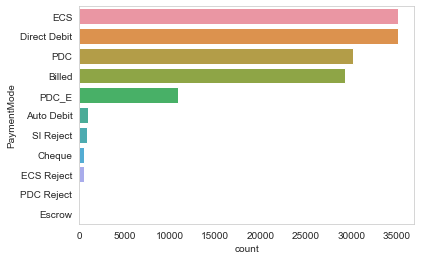

In [443]:
plot_countplot(df['PaymentMode'])

In [424]:
print("extracting dual features...")

ratio_features_list = [
    ('DisbursalAmount', 'AssetCost'),
    ('AssetCost', 'MonthlyIncome'),
    ('EMI', 'MonthlyIncome'),
]

ratio_features = get_dual_features(df, ratio_features_list)
print(f'ratio features: {ratio_features.shape}')

multiply_features_list = [
    ('EMI', 'Tenure'),
]
multiply_features = get_dual_features(df, multiply_features_list, 'multiply')
print(f'multiply features: {multiply_features.shape}')
df = pd.concat([df, ratio_features, multiply_features], axis=1)

difference_features_list = [
    ('AssetCost', 'DisbursalAmount'),
    ('AmountFinance', 'DisbursalAmount'),
    ('AssetCost', 'AmountFinance'),
    ('mu_con_EMI_Tenure', 'AssetCost'),
    ('MaturityDAte', 'DisbursalDate'),
]
difference_features = get_dual_features(df, difference_features_list, 'difference')
print(f'difference features: {difference_features.shape}')
df = pd.concat([df, difference_features], axis=1)

# extra sauce
df['di_con_MaturityDAte_DisbursalDate'] = df['di_con_MaturityDAte_DisbursalDate'].map(lambda d: d.days)

del ratio_features, multiply_features, difference_features

extracting dual features...
getting ratio features...
ratio features: (143400, 3)
getting multiply features...
multiply features: (143400, 1)
getting difference features...
difference features: (143400, 5)


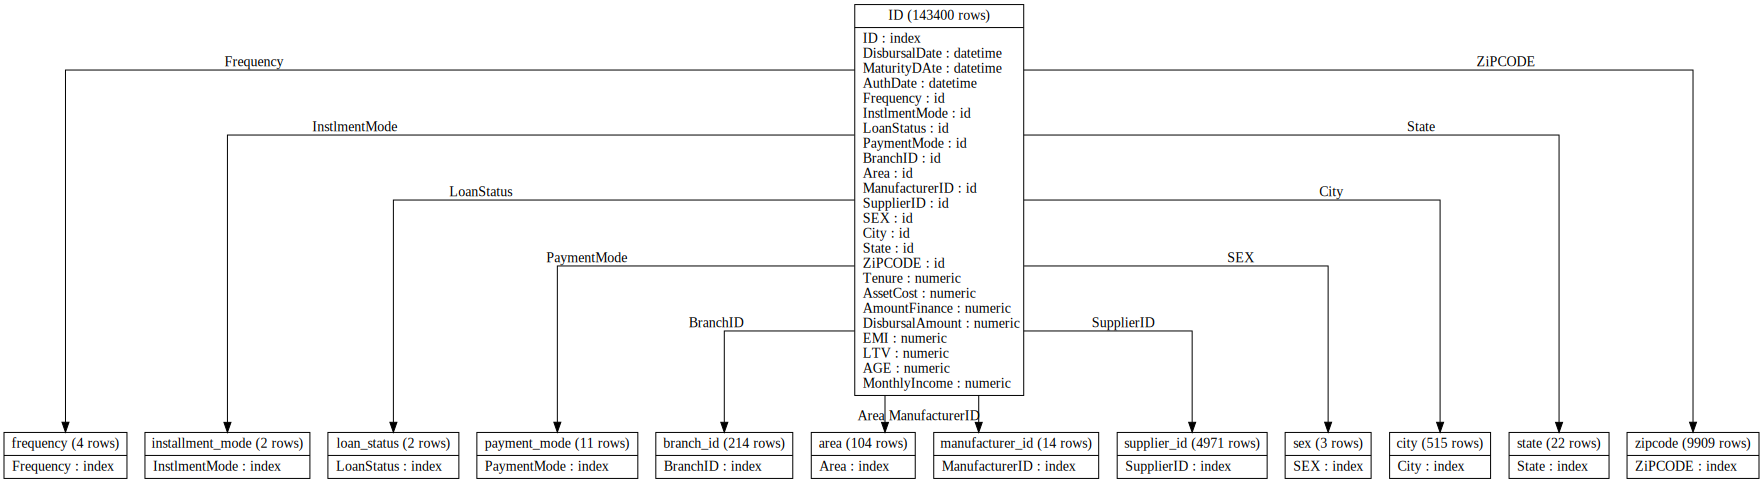

In [408]:
es = ft.EntitySet()

# entity_id: entity_index
entities_mapping = {
    'frequency': 'Frequency',
    'installment_mode': 'InstlmentMode',
    'loan_status': 'LoanStatus',
    'payment_mode': 'PaymentMode',
    'branch_id': 'BranchID',
    'area': 'Area',
    'manufacturer_id': 'ManufacturerID',
    'supplier_id': 'SupplierID',
    'sex': 'SEX',
    'city': 'City',
    'state': 'State',
    'zipcode': 'ZiPCODE', # 444511
}

ft_features = {
    'ID' : ft.variable_types.Index,
    'DisbursalDate': ft.variable_types.Datetime,
    'MaturityDAte': ft.variable_types.Datetime,
    'AuthDate': ft.variable_types.Datetime,
}

for entity_id, entity_index in entities_mapping.items():
    es = es.entity_from_dataframe(entity_id=entity_id, dataframe=pd.DataFrame(df[entity_index].unique(), columns=[entity_index]), index=entity_index)
    ft_features[entity_index] = ft.variable_types.Id

    
# ==========================================
# Adding other variables
# ==========================================
ft_features['Tenure'] = ft.variable_types.Numeric 
ft_features['AssetCost'] = ft.variable_types.Numeric 
ft_features['AmountFinance'] = ft.variable_types.Numeric 
ft_features['DisbursalAmount'] = ft.variable_types.Numeric 
ft_features['EMI'] = ft.variable_types.Numeric 
ft_features['LTV'] = ft.variable_types.Numeric 
ft_features['AGE'] = ft.variable_types.Numeric 
ft_features['MonthlyIncome'] = ft.variable_types.Numeric 

# ======================
# Adding Main Entity
# ======================
# WARNING: Using only `df_train_dataset` and `df_test_dataset`
es = es.entity_from_dataframe(entity_id="ID", dataframe=df[list(ft_features.keys())].copy(), index="ID", variable_types=ft_features)

# ==========================================
# Adding Relationships in Loop
# ==========================================
for entity_id, entity_index in entities_mapping.items():
    es = es.add_relationship(ft.Relationship(es[entity_id][entity_index], es["ID"][entity_index]))

es.plot()

In [449]:
ft_args = namedtuple('ft_args', [
    'entity_name', 
    'target_entity', 
    'target_entity_id',
    'ignore_variables',
    'ignore_entities',
    'agg_primitives',
    'trans_primitives',
    'interesting_values',
    'where_primitives',
    'drop_exact',
    'max_depth',
    'primitive_options',
])


# ['mean', 'std', 'max', 'min', 'num_unique', 'count', 'percent_true']
# https://stackoverflow.com/questions/62193884/use-featuretools-on-specific-columns-only

target_entities = [
    ft_args('id_et', 
            target_entity='ID', 
            target_entity_id='ID', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=[],
            trans_primitives=[
                'day', 
                'month', 
                'year', 
                'week', 
                'weekday', 
                'is_weekend',
            ],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=list(ft_features.keys()),
            max_depth=1,
            primitive_options=None,
            ),
    ft_args('frequency_et', 
            target_entity='frequency', 
            target_entity_id='Frequency', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('installment_mode_et', 
            target_entity='installment_mode', 
            target_entity_id='InstlmentMode', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('loan_status_et', 
            target_entity='loan_status', 
            target_entity_id='LoanStatus', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('payment_mode_et', 
            target_entity='payment_mode', 
            target_entity_id='PaymentMode', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique', 'max'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options={
                ('max'): {
                    'include_variables': {
                        'ID': ['LTV']
                    }
                }
            }
    ),
    # ['mean', 'std', 'max', 'min', 'num_unique', 'count', 'percent_true']
    ft_args('branch_id_et', 
            target_entity='branch_id', 
            target_entity_id='BranchID', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique', 'max'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options={
                ('max'): {
                    'include_variables': {
                        'ID': ['LTV']
                    }
                }
            }
    ),
    ft_args('area_et', 
            target_entity='area', 
            target_entity_id='Area', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('manufacturer_id_et', 
            target_entity='manufacturer_id', 
            target_entity_id='ManufacturerID', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique', 'max'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options={
                ('max'): {
                    'include_variables': {
                        'ID': ['LTV']
                    }
                }
            }
    ),
    ft_args('supplier_id_et', 
            target_entity='supplier_id', 
            target_entity_id='SupplierID', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique', 'max'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options={
                ('max'): {
                    'include_variables': {
                        'ID': ['LTV']
                    }
                }
            }
    ),
    ft_args('sex_et', 
            target_entity='sex', 
            target_entity_id='SEX', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('city_et', 
            target_entity='city', 
            target_entity_id='City', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('state_et', 
            target_entity='state', 
            target_entity_id='State', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'num_unique'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[],
            max_depth=2,
            primitive_options=None
    ),
    ft_args('zipcode_et', 
            target_entity='zipcode', 
            target_entity_id='ZiPCODE', 
            ignore_variables=None, 
            ignore_entities=[], 
            agg_primitives=['count', 'mean', 'std', 'max', 'min', 'num_unique'],
            trans_primitives=[],
            interesting_values=[],
            where_primitives=[], 
            drop_exact=[
                'NUM_UNIQUE(ID.LoanStatus)',
                'NUM_UNIQUE(ID.SEX)',
                'NUM_UNIQUE(ID.InstlmentMode)',
                'NUM_UNIQUE(ID.Frequency)',
            ],
            max_depth=2,
            primitive_options=None
    ),
]

In [450]:
MAX_DEPTH, N_JOBS = 2, psutil.cpu_count()
features = {te.entity_name : dict() for te in target_entities}
for te in tqdm(target_entities):
  
    features[te.entity_name]['id'] = te.target_entity_id
    
    # assign interesting values only when required by where_primitives
    for iv in te.interesting_values:
        es['ID'][iv].interesting_values = df[iv].unique().tolist()
    
    features[te.entity_name]['defs'] = ft.dfs(entityset=es, target_entity=te.target_entity, ignore_entities=te.ignore_entities, 
                                        ignore_variables=te.ignore_variables, agg_primitives=te.agg_primitives, trans_primitives=te.trans_primitives, 
                                        max_depth=te.max_depth, drop_exact=te.drop_exact, n_jobs=N_JOBS, verbose=True, primitive_options=te.primitive_options,
                                        where_primitives=te.where_primitives, features_only=True)
    
    # unassign interesting values
    for iv in list(es['ID'].variable_types.keys()):
        es['ID'][iv].interesting_values = []

Built 18 features
Built 1 features
Built 1 features
Built 1 features
Built 27 features
Built 25 features
Built 24 features
Built 25 features
Built 25 features
Built 1 features
Built 24 features
Built 28 features
Built 40 features



In [452]:
features['payment_mode_et']['defs']

[<Feature: COUNT(ID)>,
 <Feature: MAX(ID.LTV)>,
 <Feature: MEAN(ID.AGE)>,
 <Feature: MEAN(ID.AmountFinance)>,
 <Feature: MEAN(ID.AssetCost)>,
 <Feature: MEAN(ID.DisbursalAmount)>,
 <Feature: MEAN(ID.EMI)>,
 <Feature: MEAN(ID.LTV)>,
 <Feature: MEAN(ID.MonthlyIncome)>,
 <Feature: MEAN(ID.Tenure)>,
 <Feature: NUM_UNIQUE(ID.Area)>,
 <Feature: NUM_UNIQUE(ID.BranchID)>,
 <Feature: NUM_UNIQUE(ID.City)>,
 <Feature: NUM_UNIQUE(ID.Frequency)>,
 <Feature: NUM_UNIQUE(ID.InstlmentMode)>,
 <Feature: NUM_UNIQUE(ID.ManufacturerID)>,
 <Feature: NUM_UNIQUE(ID.State)>,
 <Feature: NUM_UNIQUE(ID.SupplierID)>,
 <Feature: NUM_UNIQUE(ID.ZiPCODE)>,
 <Feature: STD(ID.AGE)>,
 <Feature: STD(ID.AmountFinance)>,
 <Feature: STD(ID.AssetCost)>,
 <Feature: STD(ID.DisbursalAmount)>,
 <Feature: STD(ID.EMI)>,
 <Feature: STD(ID.LTV)>,
 <Feature: STD(ID.MonthlyIncome)>,
 <Feature: STD(ID.Tenure)>]

In [453]:
features = {te.entity_name : dict() for te in target_entities}
for te in tqdm(target_entities):
  
    file_path = Path(f'storage/ftools_{te.entity_name}.pkl')
    if os.path.isfile(file_path):
        continue
        
    features[te.entity_name]['id'] = te.target_entity_id
    
    # assign interesting values only when required by where_primitives
    for iv in te.interesting_values:
        es['ID'][iv].interesting_values = df[iv].unique().tolist()
        
    features[te.entity_name]['features'], features[te.entity_name]['defs'] = ft.dfs(entityset=es, target_entity=te.target_entity, ignore_entities=te.ignore_entities, 
                                                            ignore_variables=te.ignore_variables, agg_primitives=te.agg_primitives, trans_primitives=te.trans_primitives, 
                                                            max_depth=te.max_depth, drop_exact=te.drop_exact, n_jobs=N_JOBS, verbose=True, primitive_options=te.primitive_options,
                                                            where_primitives=te.where_primitives, features_only=False)
                                                            
    
    # unassign interesting values
    for iv in list(es['ID'].variable_types.keys()):
        es['ID'][iv].interesting_values = []
        
    features[te.entity_name]['features'].columns = [f"{te.entity_name}_con_{c}" for c in features[te.entity_name]['features'].columns]
    features[te.entity_name]['features'].to_pickle(file_path)
    ft.save_features(features[te.entity_name]['defs'], Path(f'storage/{te.entity_name}_defs.json').__str__())

Built 27 features
EntitySet scattered to 4 workers in 14 seconds                                                                         
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Built 25 features
EntitySet scattered to 4 workers in 9 seconds                                                                          
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Built 25 features
EntitySet scattered to 4 workers in 9 seconds                                                                          
Elapsed: 00:01 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████
Built 25 features
EntitySet scattered to 4 workers in 9 seconds                                                                          
Elapsed: 00:03 | Progress: 100%|████████████████████████████████████████████████████████

In [454]:
features = {te.entity_name : dict() for te in target_entities}
for te in target_entities:
    features[te.entity_name]['id'] = te.target_entity_id
    features[te.entity_name]['features'] = pd.read_pickle(f'storage/ftools_{te.entity_name}.pkl')

In [455]:
for te_name, te_features in tqdm(features.items()):
    df = df.merge(features[te_name]['features'], left_on=features[te_name]['id'], right_on=features[te_name]['id'], how='left', suffixes=('_suffix', ''))
    df = df.drop([c for c in df.columns if '_suffix' in c], axis=1)
    print(df.shape)

(143400, 54)
(143400, 55)
(143400, 56)
(143400, 57)
(143400, 84)
(143400, 109)
(143400, 133)
(143400, 158)
(143400, 183)
(143400, 184)
(143400, 208)
(143400, 236)
(143400, 276)



# Model

In [456]:
ft_con_cols = [c for c in df.columns if '_con_' in c]

In [392]:
con_cols = [
    'Tenure',
    'AssetCost',
    'AmountFinance',
    'DisbursalAmount',
    'EMI',
    'LTV',
    'AGE',
    'MonthlyIncome',
    'DisbursalDate',
    'MaturityDAte',
    'AuthDate'
] + ft_con_cols

cat_cols = [
    'Frequency',
    'InstlmentMode',
    'LoanStatus',
    'PaymentMode',
    'BranchID',
    'Area',
    'ManufacturerID',
    'SupplierID',
    'SEX',
    'City',
    'State',
    'ZiPCODE',
]

In [393]:
print("encoding target...")
target_encoder = LabelEncoder()
df.loc[df['source'] == 'train', 'Top-up Month'] = target_encoder.fit_transform(df[df['source'] == 'train']['Top-up Month'])

encoding target...


In [394]:
print("encoding date and categorical features...")
oe = OrdinalEncoder(return_df=False, handle_missing='return_nan', handle_unknown='error', drop_invariant=False)
df[cat_cols] = oe.fit_transform(df[cat_cols]) - 1

df[cat_cols] = df[cat_cols].fillna(-1)

fucnT = FunctionTransformer(lambda X: X.astype('int'))
df[cat_cols] = fucnT.fit_transform(df[cat_cols])

for col in ['DisbursalDate', 'MaturityDAte', 'AuthDate']:
    df[col] = df[col].map(date_to_integer)

encoding date and categorical features...


In [395]:
df[con_cols] = df[con_cols].replace([np.inf, -np.inf], np.nan)

## Modelling

In [396]:
train, test = df[df['source'] == 'train'], df[df['source'] == 'test']

In [397]:
config = dict()
config["lgb_params"] = {
    "num_classes": train['Top-up Month'].unique().size,
    "objective": "multiclass",
    "boosting_type": "gbdt",
    "metric" : "multi_logloss",
    "num_threads" : psutil.cpu_count()
}
config["xgb_params"] = {
    "num_class": train['Top-up Month'].unique().size,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "nthread" : psutil.cpu_count()
}
config["cgb_params"] = {
    "classes_count": train['Top-up Month'].unique().size,
    "objective": "MultiClass",
    "eval_metric": "MultiClass",
    "thread_count" : psutil.cpu_count()
}

if IN_COLAB:
    config["lgb_params"]['device'] = 'gpu'
    config["lgb_params"]['gpu_platform_id'] = 1
    config["lgb_params"]['gpu_device_id'] = 0
    
    config["lgb_params"]['tree_method'] = 'gpu_hist'
    
    config["lgb_params"]['task_type'] = 'GPU'

In [398]:
params = config["lgb_params"]
# params = config["xgb_params"]
# params = config["cgb_params"]
predictors = cat_cols + con_cols
preds_, models = run_LGB(params, train, test, predictors, n_folds=5, seed=21, return_models=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28339
[LightGBM] [Info] Number of data points in the train set: 102924, number of used features: 239
[LightGBM] [Info] Start training from score -2.740427
[LightGBM] [Info] Start training from score -4.827576
[LightGBM] [Info] Start training from score -3.991085
[LightGBM] [Info] Start training from score -3.605801
[LightGBM] [Info] Start training from score -3.753949
[LightGBM] [Info] Start training from score -3.566869
[LightGBM] [Info] Start training from score -0.186165
Training until validation scores don't improve for 100 rounds
[30]	train's multi_logloss: 0.49634	eval's multi_logloss: 0.596398
[60]	train's multi_logloss: 0.439937	eval's multi_logloss: 0.595594
[90]	train's multi_logloss: 0.399651	eval's multi_logloss: 0.597525
[120]	train's multi_logloss: 0.366856	eval's multi_logloss: 0.

In [399]:
fi = {k: v for k, v in zip(predictors, models[0].feature_importance())}

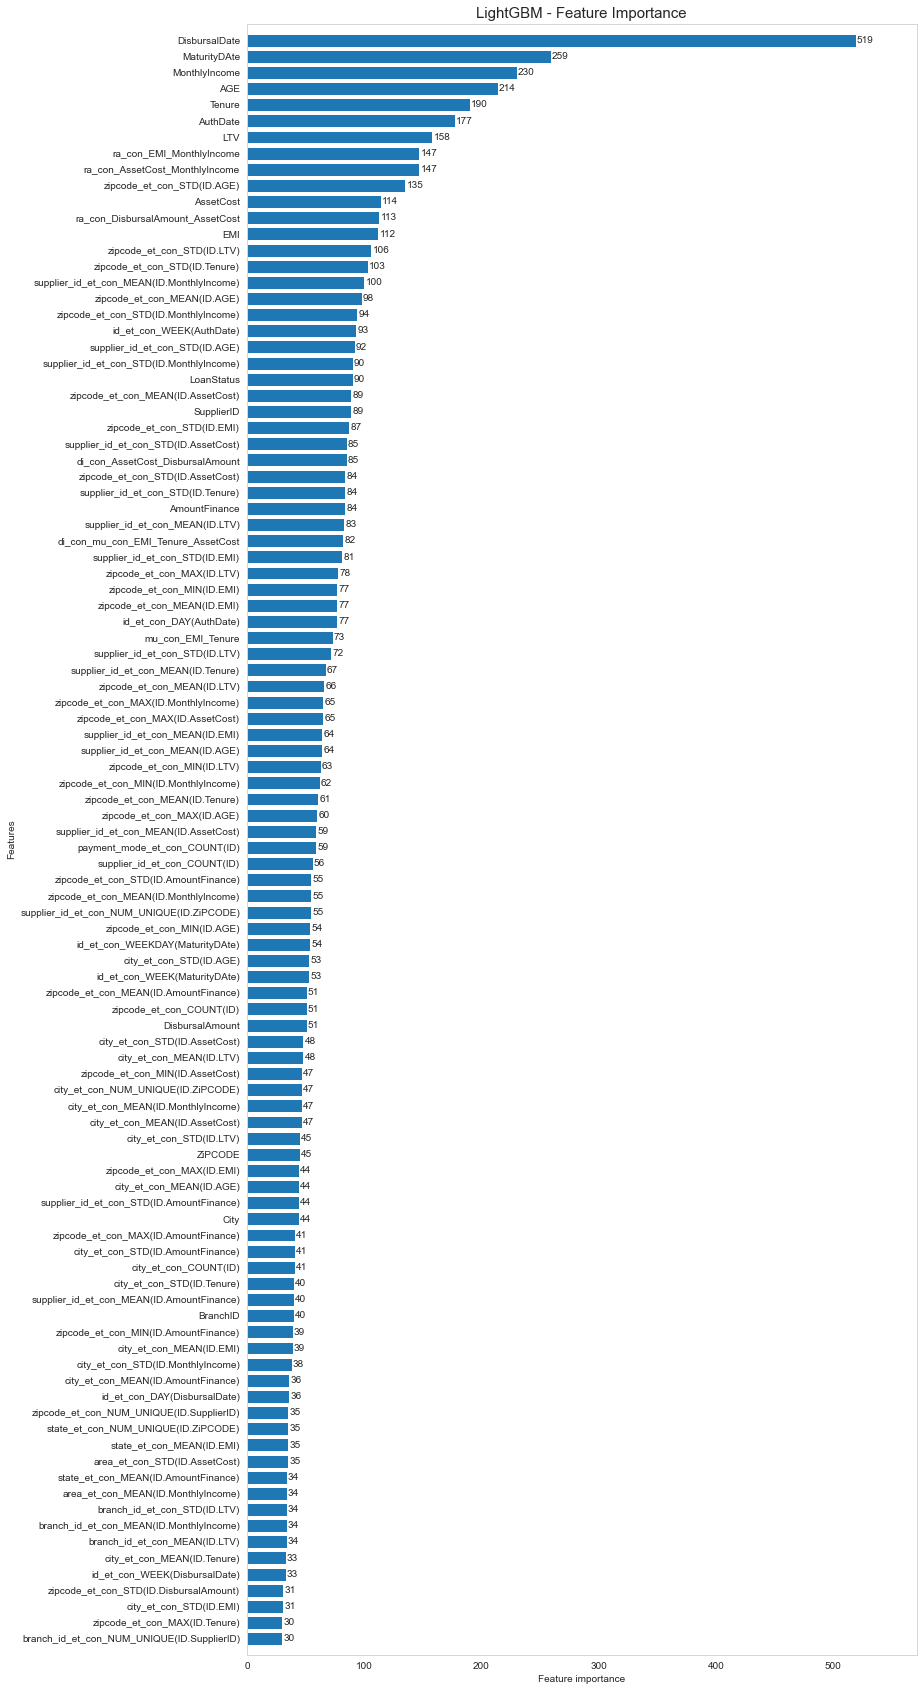

In [400]:
fig, ax = plt.subplots(figsize=(12, 30))
lgb.plot_importance(models[0], max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [401]:
final_preds = target_encoder.inverse_transform(np.argmax(preds_, axis=1))

test_ids = test["ID"].values
df = pd.DataFrame({"ID" : test_ids, "Top-up Month" : final_preds})
df.to_csv(f"submissions/submission_{datetime.now().strftime('%Y%m%d%H%M%S')}.csv", index = False)

In [402]:
Counter(final_preds)

Counter({'No Top-up Service': 14701,
         ' > 48 Months': 21,
         '24-30 Months': 6,
         '18-24 Months': 2,
         '30-36 Months': 10,
         '36-48 Months': 3,
         '12-18 Months': 2})

In [336]:
Counter(final_preds)

Counter({'No Top-up Service': 14700,
         ' > 48 Months': 21,
         '24-30 Months': 9,
         '36-48 Months': 5,
         '30-36 Months': 8,
         '12-18 Months': 2})

In [223]:
Counter(final_preds)

Counter({'No Top-up Service': 14707,
         ' > 48 Months': 20,
         '24-30 Months': 2,
         '36-48 Months': 3,
         '30-36 Months': 8,
         '18-24 Months': 1,
         '12-18 Months': 4})